Создадим датамет релевантных пар запрос-документ из наших документов. Сделаем это с помощью модели Llama-3.2-90B-Vision-Instruct-Turbo.

Менее очевидные релевантные пары важнее для тестирования, поэтому мы попросим модель генерировать запросы, не содержащие заголовок статьи. Этого недостаточно, чтобы модель действительно сгенерировать такой запрос, поэтому мы попросим её проверить себя, и, если во всех запросах присутствует заголовок, запускаем её заново.

Функция ниже генерирует запросы для одного файла с документами. Иногда модель ломается, поэтому иногда приходилось немного менять функцию и доделывать вручную.

In [1]:
import os
import re
import sys
import glob
import gensim
import numpy as np
import pandas as pd
from tqdm import tqdm
from uuid import uuid4
from functools import reduce
from multiprocessing import Pool
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords

def _remove_non_printed_chars(string):
    reg = re.compile('[^a-zA-Zа-яА-ЯёЁ]')
    return reg.sub(' ', string)

def _remove_stop_words(string,sw=[]):
    return ' '.join([word if word not in sw else '' \
                     for word in string.strip().split(' ')])

def _trim_string(string):
    # remove extra spaces, remove trailing spaces, lower the case 
    return re.sub('\s+',' ',string).strip().lower()
    
def clean_string(string,
                 stop_words_list,
                 min_len=2,
                 max_len=30):

    string = _remove_non_printed_chars(string)
    string = _remove_stop_words(string,stop_words_list)
    string = _trim_string(string)
    # also remove short words, most likely containing addresses / crap / left-overs / etc remaining after removal
    # gensim mostly does the same as above, it is used here for simplicity
    string = ' '.join(gensim.utils.simple_preprocess(string,
                                                     min_len=min_len,
                                                     max_len=max_len))
    return string
    
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)
    
def remove_special_chars(text,char_list):
    for char in char_list:
        text=text.replace(char,'')
    return text.replace(u'\xa0', u' ')

def splitkeepsep(s, sep):
    cleaned = []
    s = re.split("(%s)" % re.escape(sep), s)
    for _ in s:
        if _!='' and _!=sep:
            cleaned.append(sep+_)
    return cleaned

def extract_url(text):
    pattern = 'http([^"]+)'
    match = re.search(pattern, text)
    if match:
        url = match.group(0)
        return url
    else:
        return ""

def create_vector(text):
    return model.encode(text, normalize_embeddings=True)
    
def process_wiki_files(wiki_file):
    chars = ['\n']
    global sw

    with open(wiki_file, encoding='utf-8') as f:
        content = f.read()

    articles = splitkeepsep(content,'<doc id=')
    df_texts = pd.DataFrame(columns=['article_uuid','url', 'title', 'article','proc_article','proc_len'])
    emds = []
    
    for article in articles:
        uuid_text = uuid4()

        url = extract_url(article)
        article = remove_html_tags(article)
        titleIndex = article.find('\n\n')
        title = article[1:article.find('\n\n')]

        article = remove_special_chars(article[titleIndex:], chars)        
        proc_article = clean_string(article,sw)
        proc_len = len(proc_article.split(' '))

        temp_df_texts = pd.DataFrame(
            {'article_uuid': [uuid_text],
             'url': url,
             'title': title,
             'article': article,
             'proc_article':proc_article,
             'proc_len':proc_len
            })
        df_texts = pd.concat([df_texts, temp_df_texts], ignore_index=True)

        emb = create_vector(proc_article)
        emds.append(emb)
    
    return df_texts, np.array(emds)

sw_en = set(stopwords.words('english'))
sw_ru = set(stopwords.words('russian'))
sw = list(sw_ru.union(sw_en))  

/home/marat/new_venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from together import Together
import time

client = Together(api_key=TOGETHER_API_KEY)
total_res = ''

def generate_qeuries(wiki_file):
    total_res = ''
    chars = ['\n']

    with open(wiki_file, encoding='utf-8') as f:
        content = f.read()

    articles = splitkeepsep(content,'<doc id=')
    df_texts = pd.DataFrame(columns=['article_uuid','url', 'title', 'article','proc_article','proc_len'])
    emds = []
    
    for article in articles:
        uuid_text = uuid4()

        url = extract_url(article)
        article = remove_html_tags(article)
        titleIndex = article.find('\n\n')
        title = article[1:article.find('\n\n')]

        article = remove_special_chars(article[titleIndex:], chars)        
        proc_article = clean_string(article,sw)
        proc_len = len(proc_article.split(' '))

        temp_df_texts = pd.DataFrame(
            {'article_uuid': [uuid_text],
             'url': url,
             'title': title,
             'article': article,
             'proc_article':proc_article,
             'proc_len':proc_len
            })
        df_texts = pd.concat([df_texts, temp_df_texts], ignore_index=True)
    total_res = ''
    for i in range(15, len(df_texts)):
        cnt = 0
        text = 'Придумай 5 различных запросов, НЕ использующий слова "' + df_texts['title'][i] + '", для ответа на который будет релевантен этот текст:\n' + df_texts['article'][i] 
        while True:
            time.sleep(1)
            cnt += 1
            res = ''
            res2 = ''
            response = client.chat.completions.create(
                model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
                messages=[
                    {
                            "role": "user",
                            "content": [
                                    {
                                            "type": "text",
                                            "text": text
                                    }
                            ]
                    },
                ],
                max_tokens=512,
                temperature=0.7,
                top_p=0.7,
                top_k=50,
                repetition_penalty=1,
                stop=["<|eot_id|>","<|eom_id|>"],
                stream=True
            )
            for token in response:
                if hasattr(token, 'choices'):
                    if len(token.choices) > 0:
                        res = res + str(token.choices[0].delta.content)
            if len(res.split('1')) == 1:
                continue
            res = '1' + '1'.join(res.split('1')[1:])
            time.sleep(1)
            response2 = client.chat.completions.create(
                model="meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo",
                messages=[
                    {
                            "role": "user",
                            "content": [
                                    {
                                            "type": "text",
                                            "text": 'Ответь да или нет. Содержат ли все эти запросы слово ' + df_texts['title'][i] + ':\n' + res
                                    }
                            ]
                    },
                ],
                max_tokens=512,
                temperature=0.7,
                top_p=0.7,
                top_k=50,
                repetition_penalty=1,
                stop=["<|eot_id|>","<|eom_id|>"],
                stream=True
            )
            for token in response2:
                if hasattr(token, 'choices'):
                    if len(token.choices) > 0:
                        res2 = res2 + str(token.choices[0].delta.content)
            #print(res2)
            if (res2.startswith('Нет') or res2.startswith('нет') or res2.startswith('НЕТ')) or cnt == 15:
                total_res = total_res + '\n##\n' + df_texts['title'][i] + '\n#\n' + res
                print('##\n' + df_texts['url'][i] + '\n#\n' + res)
                break
    print(total_res)
    with open('data/queries/' + wiki_file.split('/')[-2] + '/' + wiki_file.split('/')[-1] + '.txt', "w") as output:
        output.write(total_res + '\n')

Были сгенерированы запросы для файлов от AA/wiki_00 до AA/wiki_09

Создадим датасет с парами релевантных и нерелевантных запросов и документов. Чтобы нерелевантные запросы были действительно нерелевантными, будем брать в качестве них запросы для документов из других файлов.

In [3]:
def to_2_dig(n):
    if n < 10:
        return '0' + str(n)
    else:
        return str(n)

In [13]:
article_by_url = dict()

for i in range(11):
    chars = ['\n']

    with open(('data/wiki/AA/wiki_' + to_2_dig(i)), encoding='utf-8') as f:
        content = f.read()

    articles = splitkeepsep(content,'<doc id=')
    df_texts = pd.DataFrame(columns=['article_uuid','url', 'title', 'article','proc_article','proc_len'])
    emds = []
    
    for article in articles:
        url = extract_url(article)
        article = remove_html_tags(article)
        titleIndex = article.find('\n\n')
        article = remove_special_chars(article[titleIndex:], chars)

        article_by_url[url] = article

q_tables = []
for i in range(11):
    with open(('data/queries/AA/wiki_' + to_2_dig(i) + '.txt'), encoding='utf-8') as f:
        df = pd.DataFrame({'url' : [], 'query' : []})
        url = ''
        prev_line = ''
        for line in f:
            if (prev_line == '##\n'):
                url = line[:-1]
            elif (line != '##\n') and (line != '#\n') and len(line) > 3 and (url != 'https://ru.wikipedia.org/wiki?curid=4'):
                line = line[3:-1]
                if line[0] == '"' and line[-1] == '"':
                    line = line[1: -1]
                if line[0] == "'" and line[-1] == "'":
                    line = line[1: -1]
                print(line)
                df.loc[len(df)] = [url, line]
            prev_line = line
        q_tables.append(df)

np.random.seed(1337)

relevance_dataset = pd.DataFrame({'url' : [], 'query' : [], 'article': [], 'relevant': []})

for i in range(len(q_tables)):
    for j in range(len(q_tables[i])):
        relevance_dataset.loc[len(relevance_dataset)] = [
            q_tables[i]['url'][j],
            q_tables[i]['query'][j],
            article_by_url[q_tables[i]['url'][j]],
            1
        ]
        relevance_dataset.loc[len(relevance_dataset)] = [
            q_tables[i]['url'][j],
            q_tables[(i + 5) % 9]['query'][np.random.randint(0, len(q_tables[(i + 5) % 9]) - 1)],
            article_by_url[q_tables[i]['url'][j]],
            0
        ]

#relevance_dataset.to_csv('data/relevance_dataset.csv')

Какая страна расположена в Северной Европе и имеет выход к Балтийскому морю?
Какой город является столицей страны, о которой говорится в тексте?
Какой язык является государственным языком страны, о которой говорится в тексте?
Какая страна является членом ООН, ОБСЕ, Совета Европы, ВТО, Европейского союза, НАТО и ОЭСР?
Какая страна имеет самую большую площадь среди прибалтийских государств?
Какая страна является крупнейшим государством в мире по площади?
Какая страна граничит с 18 государствами мира?
Какая страна является постоянным членом Совета Безопасности ООН с правом вето?
Какая страна является ядерной державой и одной из ведущих космических держав мира?
Какая страна является членом международных организаций, таких как ООН, G20, ЕАЭС, СНГ, ОДКБ, ВТО, ОБСЕ, ШОС, АТЭС, БРИКС, МОК и других?
Самые крупные наземные млекопитающие
Животные с длинными хоботами
Млекопитающие с большими ушами
Животные, которые живут в Африке и Азии
Самые умные животные в мире
Какие животные жили на Земле 5 ми

Сделаем функцию, которая по данной функции, оценивающей релевантность строит для неё ROC-кривую

In [14]:
import matplotlib.pyplot as plt

def eval_model(rel_f, N = len(relevance_dataset)):
    estimated = np.zeros(N)
    for i in range(N):
        estimated[i] = rel_f(relevance_dataset['query'][i], relevance_dataset['article'][i])
    arr = relevance_dataset['relevant'].to_numpy()[:N][np.argsort(estimated)]
    FN = np.hstack((np.zeros(1), np.cumsum(arr)))
    TN = np.arange(0, N + 1) - FN
    TP = (N // 2) - FN
    FP = (N // 2) - TN
    ax = plt.gca()
    ax.set_xlabel("FPR", fontsize=15)
    ax.set_ylabel("TPR", fontsize=15)
    plt.plot(FP / (FP + TN), TP / (TP + FN))
    plt.show()
    return [FP / (FP + TN), TP / (TP + FN)]

В качестве модели оценки релевантности возьмём следующую модель:

In [15]:
from sentence_transformers import CrossEncoder

reranker_model = CrossEncoder('DiTy/cross-encoder-russian-msmarco', max_length=512, device='cpu')

def msmarco_rel(q, doc):
    predict_result = reranker_model.predict([[q, doc]])[0]
    return predict_result

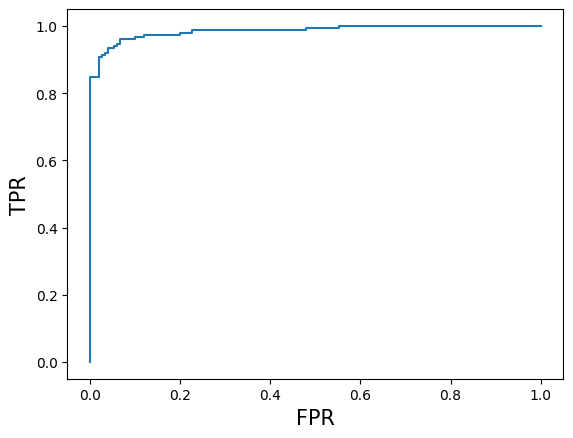

In [16]:
marco_FPR, marco_TPR = eval_model(msmarco_rel, N = 300)